In [1]:
from matplotlib import pyplot as plt
import numpy as np
import re
import scipy as sp
from scipy import stats
import seaborn as sns

%matplotlib inline

In [2]:
sequences = []
cur_seq = None

with open("../data/fasta/mammalia_vWF_trim.fasta", "r") as f:
    for line in f:
        if line[0] == ">":
            if cur_seq is not None:
                sequences.append(cur_seq)
            cur_seq = {"name": line, "lines": []}
        else:
            cur_seq["lines"].append(line)

In [3]:
sequences = [seq for seq in sequences if len(seq["lines"]) > 1900 // 60]
sequences = [seq for seq in sequences if re.match(r">([a-z]+)\|([A-Z0-9]+)\|([A-Z0-9_]+) von Willebrand factor OS", seq["name"])]

In [4]:
with open("../data/fasta/vWF_mammalia_trim.fa", "w") as f:
    for seq in sequences:
        f.write(seq["name"])
        for line in seq["lines"]:
            f.write(line)

In [5]:
datas = []

for i in np.arange(4, 3552, 71):
    data = !cat ../data/alignment_5.clustal_num | tail -n +$i | head -n 69
    datas.append(data)

In [6]:
seq_dict = dict()

for r_i, data in enumerate(datas):
    for d in data:
        if r_i == 0:
            seq_dict[d.split(" ")[0].split("|")[2]] = d.split(" ")[-1].split("\t")[0]
            
        else:
            seq_dict[d.split(" ")[0].split("|")[2]] += d.split(" ")[-1].split("\t")[0]

In [7]:
aas = "A C D E F G H I K L M N P Q R S T V W Y -".split(" ")

In [8]:
def freq(l):
    freq_arr = np.zeros((len(aas), ), dtype=np.uint32)
    for a in l:
        if a in aas:
            freq_arr[aas.index(a)] += 1
    return freq_arr

result = np.zeros((len(list(seq_dict.values())[0]), len(aas)))
for i, tpl in enumerate(zip(*seq_dict.values())):
    result[i] = freq(tpl)

In [9]:
result.shape

(2968, 21)

In [10]:
entropy = np.zeros((result.shape[0], ))

for pos in range(result.shape[0]):
    entropy[pos] = stats.entropy(result[pos, :] / result[pos, :].sum())
    
l = np.where(np.array(list(seq_dict["VWF_HUMAN"])) != "-")[0]
START, FINISH = l[0], l[-1]
positions = [i for i in np.where(entropy < .5)[0] if i > START and i < FINISH]

In [11]:
indices = np.cumsum(np.array([(0 if c == "-" else 1) for c in seq_dict["VWF_HUMAN"]]))
out_of_margin = np.where(entropy <= np.percentile(entropy, 2.5))
real_indices = indices[out_of_margin]

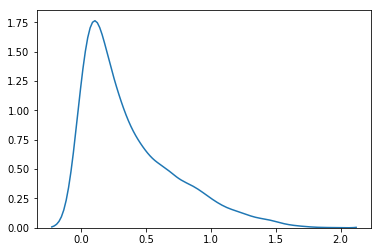

In [116]:
sns.kdeplot(entropy)

In [26]:
human_indices = np.where(np.array([(0 if c == "-" else 1) for c in seq_dict["VWF_HUMAN"]]))[0]

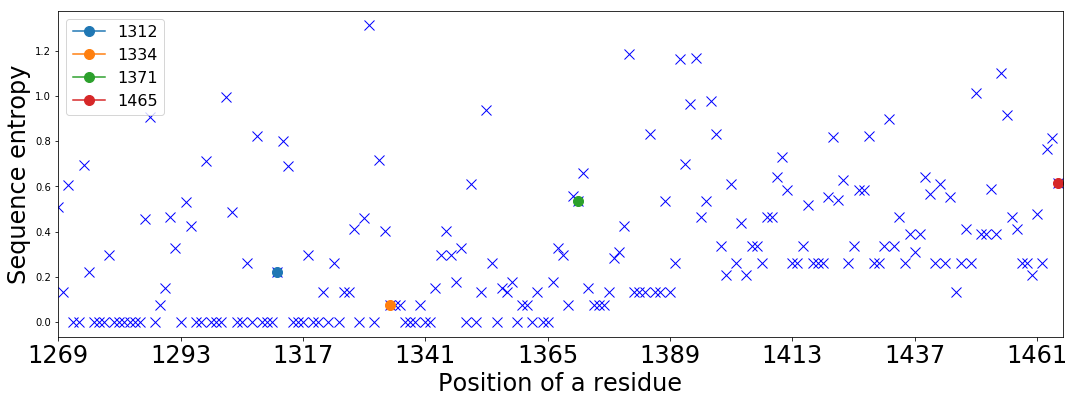

In [119]:
fig = plt.figure(figsize=(18, 6))
START = 1269
FINISH = 1269 + 198 - 1
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Position of a residue", fontdict={"size": 24})
ax.set_ylabel("Sequence entropy", fontdict={"size": 24})
ax.set_xlim(START, FINISH)
ax.set_xticks(np.arange(START, FINISH, (FINISH - START) // 8))
ax.set_xticklabels(np.arange(START, FINISH, (FINISH - START) // 8), fontdict={"size": 24})
md_indices = np.array([1312, 1334, 1371, 1465])
plt.plot(np.arange(START, FINISH), 
         entropy[human_indices][START-1:FINISH-1], 
         "bx", 
         markersize=10)
for md_idx in md_indices:
    plt.plot(md_idx, 
             entropy[human_indices][md_idx - 1], 
             marker="o", 
             markersize=10, 
             label=md_idx)
plt.legend(fontsize=16)